In [1]:
import numpy as np
import cvxpy as cp
import sympy as sym
import pandas as pd
import cvxpy as cp
import tensorflow as tf
import torch 
from cvxpylayers.tensorflow import CvxpyLayer
# from sklearn import preprocessing
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.colors as mcolors

%run Functs.ipynb
%run GSSP.ipynb
%run PGMB.ipynb
%run Proximal.ipynb

### Compare Portfolios

**Aproaches:**<br>
**(1)** Equaly weighed portfolio: $${w}_{opt} = {w}_{ew} = \frac{1}{N}1$$

**(2)** Least squares problem(solved using cvxpy): $${w}_{opt} = \textrm{arg min} \lVert Xw - r^{*} 1 \lVert^{2}_{2}$$

**(3)** Lasso problem(proximal gradient descent): $${w}_{opt} = \textrm{arg min} \lVert Xw - r^{*} 1 \lVert^{2}_{2} +\lambda\lVert w \lVert_{1}$$
Solved by implementing gradient descent and soft thresholding the result by $\lambda\tau$ after each step:
                                    $$prox_{L1}(\beta) = S_{\lambda\tau}(\beta) $$
                                    with $\beta$ being the result of a gradient descent step of the least squares equation.

**(4-5)** Sparse-Convex approach. Find a k-sparse portfolio wk that
replicates performance of the (very non-sparse) equally weighted
portfolio $w_{ew}$ . Amounts to solving: $${w}_{opt} = \textrm{arg min} \lVert Xw - Xw_{ew} \lVert^{2}_{2}$$
Solved using Gradient Descent (solutions 3 and 4 are for k=5 and k=10 respectively).
<br>
<br>
**Constraints of every problem:** $$\quad w^{\top}\hat{\mu}=r^{*} $$
                              $$w^{\top}=1 $$
                              $$w_{i}\geq{0} $$


In [2]:
def loss_fn(X, Y, w):
    return cp.norm2(X @ w - Y)**2

def regularizer(w):
    return cp.norm1(w)

def objective_fn(X, Y, w, lambd):
    return loss_fn(X, Y, w) + lambd * regularizer(w)

In [4]:
train_data = pd.read_csv(r'Data.csv', header=None)
train_data.columns=np.arange(train_data.shape[1])

In [5]:
RR = train_data/100
numportfolios = 7
MonthlyReturns = np.zeros((numportfolios,360));
AnnualReturns = np.zeros((numportfolios,30));
rho = 0.1/12; # `annualised' return of 10%
y = rho*np.ones(60);

In [6]:
for i in range (60,409,12):
    print((i/12) - 5)
    portfolios = np.zeros((numportfolios,train_data.shape[1]));
    Phi = RR[i-60:i]
    
#equally weighted portfolio
    portfolios[0] = np.ones(48)/48
    
#CVX least squares   
    w = cp.Variable(48, nonneg=True)
    least_squares_cost = cp.sum_squares(Phi.to_numpy()[0] @ w - y)
    least_squares_prob = cp.Problem(cp.Minimize(
                                    objective_fn(Phi.to_numpy()[0], y, w, 0)),
                                    [cp.sum(w) == 1,])
    
    least_squares_prob.solve()
    portfolios[1] = (w.value)
#Lasso  
    prox_y = rho*np.ones((60,1));
    x0=np.ones((48,1))/48    
    w = proximal_gradient_descent(x0,0.1,1,0.25,0.001, 200, Phi, prox_y)

    portfolios[2] = w.T

#sparse-convex
    w_ew = np.dot(Phi,np.ones((48,1)))/48
    # k=5
    x0=np.zeros((48,1))
    x0[0] = 1/2
    x0[1] = 1/2
    w = PGMB(x0,0.1,1,0.25,0.001, 200, Phi, w_ew, 5)
    portfolios[3] = w.T
    
    k=10
    x0=np.zeros((48,1))
    x0[0] = 1/2
    x0[1] = 1/2
    w = PGMB(x0,0.1,1,0.25,0.001, 200, Phi, w_ew, 10)
    portfolios[4] = w.T
    AnnualReturns[4][i//12 - 5] = sum(np.dot(RR[i:i+12],portfolios[4]))
    MonthlyReturns[4][i-60:i-48] = np.dot(RR[i:i+12],portfolios[4])
    
#CVX-layers
#Least Squares
    w = cp.Variable((48),nonneg=True)
    constraints = [cp.sum(w) == 1, w>=0]
    ls_prob = cp.Problem(cp.Minimize(
                                    objective_fn(Phi.to_numpy()[0], y, w, 0)),
                                    [cp.sum(w) == 1,])
    assert ls_prob.is_dpp()
    cvxpylayer = CvxpyLayer(ls_prob, parameters=[], variables=[w])
    A_tch = torch.randn(60, 48, requires_grad=True)
    b_tch = torch.randn(60, requires_grad=True)
    solution, = cvxpylayer()
    portfolios[5] = solution.numpy()
    
    ##cvxpy layers lasso deleted
    
#ew_replication sparse
    w = cp.Variable((48))
    A = cp.Parameter((60, 48))
    A.value = Phi.to_numpy()
    W_EW = cp.Parameter((60))
    W_EW.value = np.dot(Phi,np.ones((48)))/48
    
    cost = cp.sum_squares(A @ w - W_EW) + cp.norm1(w)
    prob = cp.Problem(
                        cp.Minimize(cost),
                        [cp.sum(w) == 1,
                        w >= 0,]
                        )

    assert prob.is_dpp()

    cvxpylayer = CvxpyLayer(prob, parameters=[A,W_EW], variables=[w])
    A_tf = tf.Variable(tf.random.normal((60, 48)))
    b_tf = tf.Variable(tf.random.normal((60,)))
    solution, = cvxpylayer(A_tf, b_tf)
    portfolios[6] = solution.numpy()
#Calculate the returns
    for x in range (len(portfolios)):
        AnnualReturns[x][i//12 - 5] = sum(np.dot(RR[i:i+12],portfolios[x]))
        MonthlyReturns[x][i-60:i-48] = np.dot(RR[i:i+12],portfolios[x])

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0


In [7]:
# Calculate the cumulative returns
CumulativeReturns = np.zeros(MonthlyReturns.shape)
for j in range(numportfolios):
    CumulativeReturns[j] = np.cumsum(MonthlyReturns[j])
CumulativeReturns

array([[0.0464    , 0.03705417, 0.02283333, ..., 4.30693958, 4.32291667,
        4.290925  ],
       [0.04550063, 0.0370802 , 0.02336412, ..., 3.80584531, 3.82197799,
        3.78983228],
       [0.02702283, 0.06015995, 0.14175088, ..., 3.9749045 , 3.98203932,
        3.95246389],
       ...,
       [0.05203113, 0.05624721, 0.02457486, ..., 4.29551206, 4.32120774,
        4.31425574],
       [0.04754666, 0.04013874, 0.02743361, ..., 4.08142213, 4.09754261,
        4.06539641],
       [0.03624184, 0.03647927, 0.03115691, ..., 3.66273783, 3.69096028,
        3.65300437]])

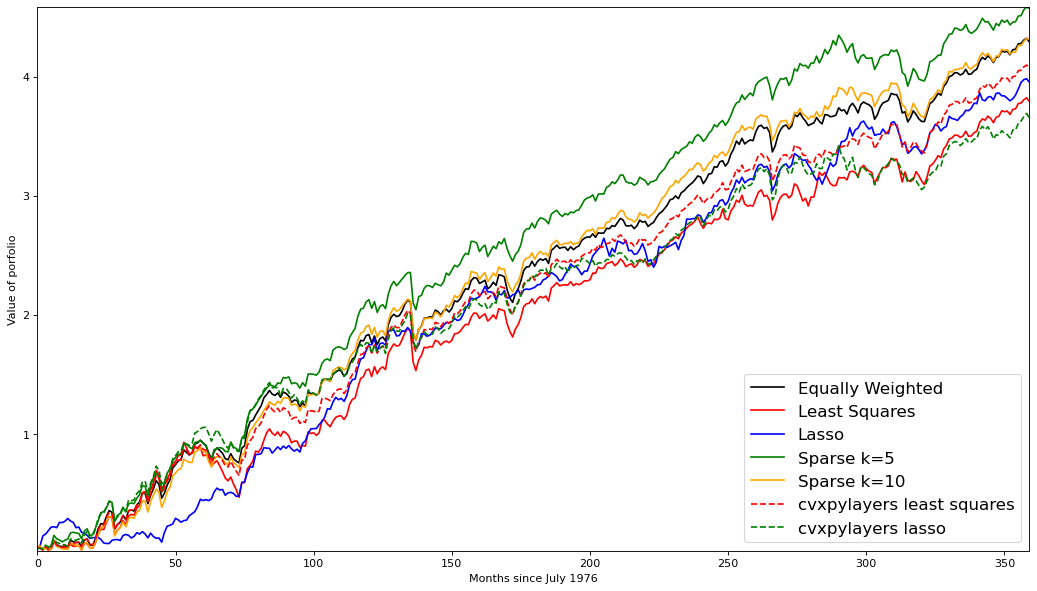

In [8]:
figure(num=None, figsize=(16, 9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(CumulativeReturns[0],color='black')
plt.plot(CumulativeReturns[1],color='red')
plt.plot(CumulativeReturns[2],color='blue')
plt.plot(CumulativeReturns[3],color='green')
plt.plot(CumulativeReturns[4],color='orange')
plt.plot(CumulativeReturns[5],color='red', linestyle='dashed')
plt.plot(CumulativeReturns[6],color='green', linestyle='dashed')


plt.margins(0)

legend = ['Equally Weighted', 'Least Squares','Lasso', 'Sparse k=5', 'Sparse k=10','cvxpylayers least squares', 'cvxpylayers lasso','cvxpylayers ew replication','cvxpylayers ew replication sparse']
plt.legend(legend ,loc = "lower right",prop={'size': 15})
plt.xlabel('Months since July 1976')
plt.ylabel('Value of porfolio')

plt.show()

### Final Portfolio Values


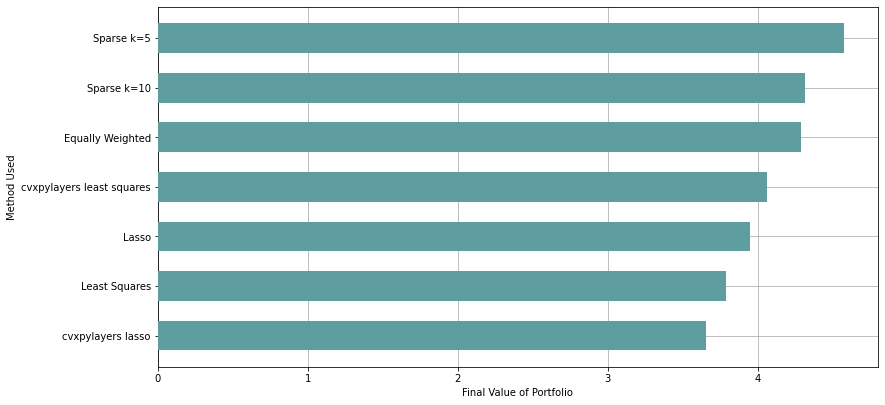

In [9]:
fig = plt.figure(figsize=(10, 5))
fig.set_facecolor("w")

ax = fig.add_axes([0,0,1,1])
Final_Returns = CumulativeReturns[:,359]

Sorted_Final_Returns = np.zeros(numportfolios)
Sorted_Legend = np.empty(numportfolios, dtype="S50")
Sorted_Final_Returns_Indexes = np.argsort(Final_Returns)

for x in range(numportfolios):
    Sorted_Final_Returns[x] = Final_Returns[Sorted_Final_Returns_Indexes[x]]
    Sorted_Legend[x] = legend[Sorted_Final_Returns_Indexes[x]]

ax.barh(Sorted_Legend,Sorted_Final_Returns, align='center',height=0.6, color='cadetblue', zorder=3)
ax.grid(zorder=0)

plt.xlabel('Final Value of Portfolio')
plt.ylabel('Method Used')
plt.show()

###  Average Annual Returns

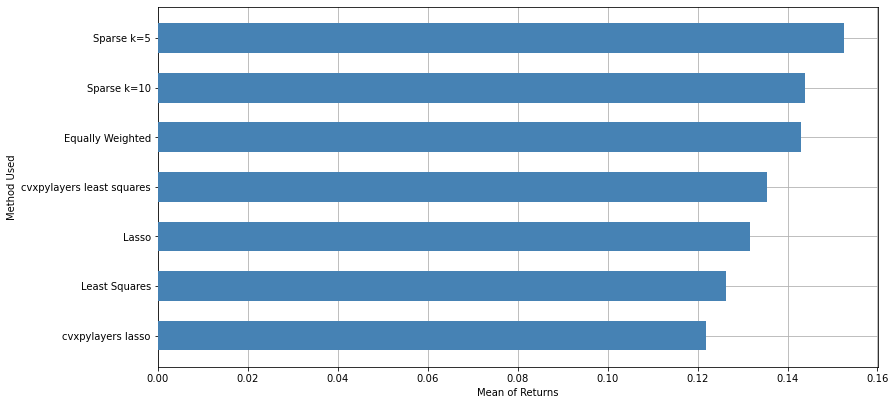

In [10]:
fig = plt.figure(figsize=(10, 5))
fig.set_facecolor("w")

ax = fig.add_axes([0,0,1,1])
Average_Returns = np.zeros(numportfolios)
for x in range(len(Average_Returns)):
    Average_Returns[x] = np.mean(AnnualReturns[x])

Sorted_Average_Returns = np.zeros(numportfolios)
Sorted_Legend = np.empty(numportfolios, dtype="S50")
Sorted_Average_Returns_Indexes = np.argsort(Average_Returns)

for x in range(len(Average_Returns)):
    Sorted_Average_Returns[x] = Average_Returns[Sorted_Average_Returns_Indexes[x]]
    Sorted_Legend[x] = legend[Sorted_Average_Returns_Indexes[x]]

ax.barh(Sorted_Legend,Sorted_Average_Returns, align='center',height=0.6, color='steelblue', zorder=3)
ax.grid(zorder=0)

plt.xlabel('Mean of Returns')
plt.ylabel('Method Used')
plt.show()